# ETPF

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from da.l63 import lorenz63
from da.scheme import rk4
from da.loss import loss_rms
from da.visualize import plot_loss
from da.etpf import EnsembleTransformParticleFilter as ETPF

In [3]:
# params
s = 10
b = 8/3
r = 28

# time step size
dt = 0.01

# obs_per
obs_per = 12

# Dt: 時間刻み
# NOTE: nature runの生成に使ったdtに対して，Dt = dt * obs_perとなるように設定．
Dt = dt * obs_per

p = (s, r, b)
# モデルの遷移関数(非線形)
# 0.01ずつ時間発展させる
# dtは同化step
def M(x, Dt):
    for i in range(int(Dt/0.01)):
        x = rk4(lorenz63, 0, x, p, 0.01)
    return x

# 単位行列
I = np.eye(3, dtype=float)

# 観測
H = I
# H = np.eye(2,3)
# H = np.eye(1,3)
print("H:", H)

# モデル誤差共分散, 最初は完全モデルを仮定
Q = np.zeros((3, 3))

# 観測誤差共分散, 後で定数倍の変化をさせる.
r0 = 1
R = r0*I

# 観測値と真値
end_step = -1 # 開発用
x_true = np.load('x_true_l63.npy')[:end_step]
y = np.load('x_obs_l63.npy')[:end_step]
if not np.isclose(r0, 1.0):
    y = x_true + np.random.normal(loc=0, scale=np.sqrt(r0), size=x_true.shape)  # R = r0*I

y = y@H.T
R = H@R@H.T

def h(x):
    return H@x

# 初期分布
seed = 1
np.random.seed(seed)
x_0 = x_true[np.random.randint(len(x_true)-1)]
P_0 = 64*I

# inflation
sigma_add = 0.4

# ensemble size
m = 20

# generate initial ensemble
X_0 = x_0 + np.random.multivariate_normal(np.zeros_like(x_0), P_0, m)  # (m, dim_x)


H: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [4]:
end = len(y)//2
etpf = ETPF(M, h, R, N_thr=.9, add_inflation=sigma_add)
etpf.initialize(X_0)
for y_obs in tqdm(y[:end]):
    etpf.forecast(Dt)
    etpf.update(y_obs)

    if False:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(*y_obs, marker='*')
        for x in etpf.X:
            ax.scatter(*x)

        ax.set_xlim([-20, 20])
        ax.set_ylim([-20, 20])
        ax.set_zlim([-20, 20])
        plt.show()
    

x_assim = etpf.x

100%|██████████| 1999/1999 [00:07<00:00, 265.98it/s]


RMSE time mean: 0.48481976892025025


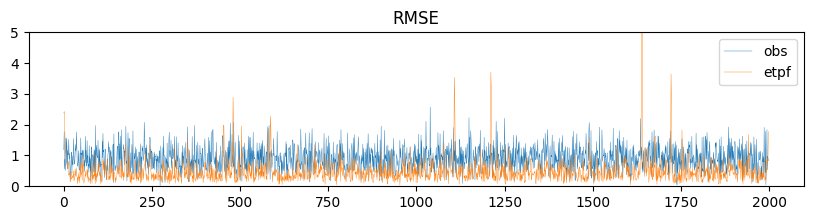

In [5]:
# plot rmse
fig, ax = plt.subplots(figsize=(10, 2))
plot_loss(x_true[:end]@H.T, y[:end], loss_rms, ax=ax, label='obs', lw=0.3)
plot_loss(x_true[:end], x_assim[:end], loss_rms, ax=ax, label='etpf', lw=0.3)
# plt.plot(np.sqrt(pf.trP), lw=0.3, label='trP')
ax.legend()
ax.set_ylim([0, 5])
ax.set_title("RMSE")
print("RMSE time mean:", loss_rms(x_true[:end], x_assim)[200:].mean())

# m vs. h

In [ ]:
def compute_rmse(simulate_params):
    m, h = simulate_params.values()
    # RUN DA
    etpf = ETPF(M, H, R, add_inflation=h, N_thr=.9)
    X_0 = x_0 + np.random.multivariate_normal(np.zeros_like(x_0), P_0, m)  # (m, dim_x)
    etpf.initialize(X_0)
    end = 1000
    for y_obs in tqdm(y[:end]):
        etpf.forecast(Dt)
        etpf.update(y_obs)

    return loss_rms(x_true[:end], etpf.x).mean()

In [ ]:
# from da.params import prod_params_kv
from da.optimize import grid_search2

m_list = [20, 40, 60]
h_list = [0.2, 0.3, 0.4]

# params_kv = prod_params_kv("m", m_list, "h", h_list)
# print(params_kv)

df = grid_search2(compute_rmse, "m", m_list, "h", h_list, n_multi=1, multi_type="process")

100%|██████████| 1000/1000 [00:10<00:00, 94.77it/s]


<Axes: >

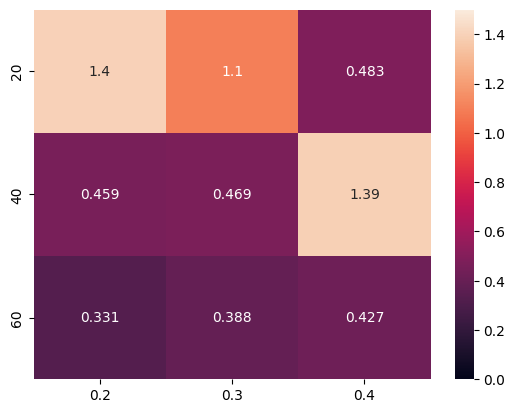

In [ ]:
import seaborn as sns
sns.heatmap(df, annot=True, fmt=".3g", vmax=np.sqrt(r0)*1.5, vmin=max([0.0, np.sqrt(r0)-1.0]))